# Features and images ensembling and fit generator

In this notebook are going see how to ensemble features with images in a classification problem.

The main idea is to show how to :
* ensemble CNN with other architectures to train a network using images and features together.
* implement a fit generator with a network with multiple inputs.

The dataset consists on features a and images of leaves from 100 different plants and the task consist of the Leaf Classification contest of [Kaggle](https://www.kaggle.com/c/leaf-classification):
> The objective of this playground competition is to use binary leaf images and extracted features, including shape, margin & texture, to accurately identify 99 species of plants. Leaves, due to their volume, prevalence, and unique characteristics, are an effective means of differentiating plant species. They also provide a fun introduction to applying techniques that involve image-based features.

The dataset loading code was taken from https://www.kaggle.com/abhmul/keras-convnet-lb-0-0052-w-visualization as well as some code.

So, to brief the idea is to generate a leaf classifier as a excuse to make an hybrid DNN.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

here we load the dataset

In [32]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img

# A large amount of the data loading code is based on najeebkhan's kernel
# Check it out at https://www.kaggle.com/najeebkhan/leaf-classification/neural-network-through-keras
root = './data'
np.random.seed(2016)
split_random_state = 7
split = .8
image_max_size = 512


def load_numeric_training(standardize=False):
    """
    Loads the pre-extracted features for the training data
    and returns a tuple of the image ids, the data, and the labels
    """
    # Read data from the CSV file
    data = pd.read_csv(os.path.join(root, 'train.csv'))
    ID = data.pop('id')

    # Since the labels are textual, so we encode them categorically
    y = data.pop('species')
    y = LabelEncoder().fit(y).transform(y)
    # standardize the data by setting the mean to 0 and std to 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values

    return ID, X, y


def load_numeric_test(scaler, standardize=False):
    """
    Loads the pre-extracted features for the test data
    and returns a tuple of the image ids, the data
    """
    test = pd.read_csv(os.path.join(root, 'test.csv'))
    ID = test.pop('id')
    # standardize the data by setting the mean to 0 and std to 1
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test


def resize_img(img, max_dim=image_max_size):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(ids, max_dim=image_max_size, center=True):
    """
    Takes as input an array of image ids and loads the images as numpy
    arrays with the images resized so the longest side is max-dim length.
    If center is True, then will place the image in the center of
    the output array, otherwise it will be placed at the top-left corner.
    """
    # Initialize the output array
    # NOTE: Theano users comment line below and
    X = np.empty((len(ids), max_dim, max_dim, 1))
    # X = np.empty((len(ids), 1, max_dim, max_dim)) # uncomment this
    for i, idee in enumerate(ids):
        # Turn the image into an array
        x = resize_img(load_img(os.path.join(root, 'images', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        x = img_to_array(x)
        # Get the corners of the bounding box for the image
        # NOTE: Theano users comment the two lines below and
        length = x.shape[0]
        width = x.shape[1]
        # length = x.shape[1] # uncomment this
        # width = x.shape[2] # uncomment this
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        # NOTE: Theano users comment line below and
        X[i, h1:h2, w1:w2, 0:1] = x
        # X[i, 0:1, h1:h2, w1:w2] = x  # uncomment this
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)


def load_train_data(split=split, random_state=None):
    """
    Loads the pre-extracted feature and image training data and
    splits them into training and cross-validation.
    Returns one tuple for the training data and one for the validation
    data. Each tuple is in the order pre-extracted features, images,
    and labels.
    """
    # Load the pre-extracted features
    ID, X_num_tr, y = load_numeric_training()
    # Load the image data
    X_img_tr = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val)


def load_test_data():
    """
    Loads the pre-extracted feature and image test data.
    Returns a tuple in the order ids, pre-extracted features,
    and images.
    """
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

print('Loading the training data...')
(X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val) = load_train_data(random_state=split_random_state)
y_tr_cat = to_categorical(y_tr)
y_val_cat = to_categorical(y_val)
print('Training data loaded!')

Loading the training data...
Training data loaded!


some inspection

number of categories

In [3]:
n_cats = len(np.unique(y_tr))
print(n_cats)

99


In [4]:
X_num_tr.shape

(792, 192)

In [5]:
X_img_tr.shape

(792, 512, 512, 1)

Note that the dataset consist of 792 samples of a vector of 192 features and a image.

Here we resized the images from the original size, to 512x512 pixels.

## DNN using only features

Here we build a deep feed forward NN using only the features.

We implement some callbacks such as Early Stopping and Reduce LR on plateau to avoid overfitting and to increase the accuracy of the model.

In [6]:
import keras
from keras import Sequential
from keras import Model
from keras.layers import ReLU, Dense, Conv2D, Softmax, Conv1D, Flatten, Dropout, Input, GlobalMaxPooling2D, MaxPooling2D, Convolution2D, Concatenate, merge
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [7]:
def features_model_seq():
    model = Sequential()
    model.add(Dense(64, input_shape = (192,), activation = 'relu', name='dense_first_layer'))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation = 'relu', name = 'dense_for_ens'))
    model.add(Dense(n_cats,activation = 'softmax', name = 'out_layer'))
    return model

In [8]:
def features_model():

    feat_input = keras.engine.input_layer.Input(shape = (192,), name = 'features_input')

#    feat_input = Input(shape = (192,), name = 'features')
    x = Dense(64, activation = 'relu', name='dense_first_layer')(feat_input)
    x = Dropout(0.3)(x)
    x = Dense(128,activation = 'relu', name = 'dense_for_ens')(x)
    out = Dense(n_cats, activation = 'softmax', name = 'out_layer')(x)

    model = Model(inputs=feat_input, outputs=out)
    
    return model

In [9]:
# model 
# model = Sequential()
# model.add(Dense(150, input_shape = (192,), activation = 'relu'))
# model.add(Dropout(0.4))
# model.add(Dense(120, activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(Dense(110, activation = 'relu'))
# model.add(Dense(105, activation = 'relu'))
# model.add(Dense(100, activation = 'relu'))
# model.add(Dense(n_cats,activation = 'softmax', name = 'out_layer'))

model = features_model()

from keras.callbacks import ReduceLROnPlateau
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                        patience=5, verbose=1, mode='auto', 
                        min_delta=0.01,  min_lr=0)
erl = EarlyStopping(monitor='val_loss',
                        patience=10, verbose=1, mode='auto', 
                        min_delta=0.01)

callbacks = [rlr,erl]

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features_input (InputLayer)  (None, 192)               0         
_________________________________________________________________
dense_first_layer (Dense)    (None, 64)                12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_for_ens (Dense)        (None, 128)               8320      
_________________________________________________________________
out_layer (Dense)            (None, 99)                12771     
Total params: 33,443
Trainable params: 33,443
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(X_num_tr, y_tr_cat, batch_size = 10, epochs = 100, validation_data=(X_num_val, y_val_cat), callbacks=[rlr, erl])

Train on 792 samples, validate on 99 samples
Epoch 1/100
792/792 [==============================] - 1s 2ms/step - loss: 4.5890 - acc: 0.0290 - val_loss: 4.5596 - val_acc: 0.1414
Epoch 2/100
792/792 [==============================] - 0s 289us/step - loss: 4.5075 - acc: 0.0997 - val_loss: 4.3680 - val_acc: 0.2222
Epoch 3/100
792/792 [==============================] - 0s 288us/step - loss: 4.1629 - acc: 0.0947 - val_loss: 3.7549 - val_acc: 0.2525
Epoch 4/100
792/792 [==============================] - 0s 286us/step - loss: 3.4854 - acc: 0.1692 - val_loss: 3.0672 - val_acc: 0.3131
Epoch 5/100
792/792 [==============================] - 0s 290us/step - loss: 2.9516 - acc: 0.2652 - val_loss: 2.5953 - val_acc: 0.5253
Epoch 6/100
792/792 [==============================] - 0s 284us/step - loss: 2.5662 - acc: 0.3258 - val_loss: 2.2841 - val_acc: 0.5758
Epoch 7/100
792/792 [==============================] - 0s 290us/step - loss: 2.3006 - acc: 0.3687 - val_loss: 2.0062 - val_acc: 0.5960
Epoch 8/100


Epoch 60/100
792/792 [==============================] - 0s 291us/step - loss: 0.2893 - acc: 0.9116 - val_loss: 0.3249 - val_acc: 0.9091
Epoch 61/100
792/792 [==============================] - 0s 285us/step - loss: 0.2988 - acc: 0.9154 - val_loss: 0.3209 - val_acc: 0.9091
Epoch 62/100
792/792 [==============================] - 0s 290us/step - loss: 0.2707 - acc: 0.9318 - val_loss: 0.3247 - val_acc: 0.9091
Epoch 63/100
792/792 [==============================] - 0s 286us/step - loss: 0.2681 - acc: 0.9255 - val_loss: 0.3303 - val_acc: 0.9091

Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 64/100
792/792 [==============================] - 0s 285us/step - loss: 0.2410 - acc: 0.9482 - val_loss: 0.3242 - val_acc: 0.9091
Epoch 65/100
792/792 [==============================] - 0s 288us/step - loss: 0.2605 - acc: 0.9293 - val_loss: 0.3207 - val_acc: 0.9091
Epoch 66/100
792/792 [==============================] - 0s 285us/step - loss: 0.2595 - acc: 0.9407 - va

### Fit generator first implementation

Here we implement a generator of keras following [a very *detailed example of how to use data generators with Keras
*](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) and a nice discussion.

In [11]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, features, targets, 
                 n_classes =99, batch_size=32,  shuffle=True):
        'Initialization'
        self.n_classes = n_classes
        self.n_vals = len(targets)
        self.list_IDs = np.arange(self.n_vals)
        self.batch_size = batch_size
        self.features = features
        self.shuffle = shuffle
        self.targets = targets
        self.targets_mc = keras.utils.to_categorical(targets, num_classes=self.n_classes)
        self.indexes = np.arange(len(self.list_IDs))
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = self.features[list_IDs_temp]
        y = self.targets_mc[list_IDs_temp]

#        # Generate data
#        for i, ID in enumerate(list_IDs_temp):
#            # Store sample
#            X[i,] = np.load('data/' + ID + '.npy')
#
#            # Store class
#            y[i] = self.labels[ID]

        return X, y

here we implement the generator for both, the training and the validation set. Note that at this point the generator only shuffles the data, but does not do nothing complicated.

Later we are going to use the generator for more complex things.

In [12]:
params = {'batch_size': 10,
          'n_classes': 99,
          'shuffle': True}

training_generator = DataGenerator(X_num_tr,y_tr, **params)
validation_generator = DataGenerator(X_num_val,y_val, **params)

In [13]:
model = features_model()

from keras.callbacks import ReduceLROnPlateau
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                        patience=5, verbose=1, mode='auto', 
                        min_delta=0.01,  min_lr=0)
erl = EarlyStopping(monitor='val_loss',
                        patience=10, verbose=1, mode='auto', 
                        min_delta=0.01)

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features_input (InputLayer)  (None, 192)               0         
_________________________________________________________________
dense_first_layer (Dense)    (None, 64)                12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_for_ens (Dense)        (None, 128)               8320      
_________________________________________________________________
out_layer (Dense)            (None, 99)                12771     
Total params: 33,443
Trainable params: 33,443
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit_generator(training_generator, 
                   validation_data=validation_generator,
                   epochs=100, callbacks = callbacks)

Epoch 1/100
79/79 [==============================] - 1s 7ms/step - loss: 4.5886 - acc: 0.0304 - val_loss: 4.5573 - val_acc: 0.1222
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 4.4956 - acc: 0.0861 - val_loss: 4.3327 - val_acc: 0.1778
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 4.1163 - acc: 0.0924 - val_loss: 3.7071 - val_acc: 0.2000
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 3.4492 - acc: 0.1671 - val_loss: 3.0140 - val_acc: 0.2889
Epoch 5/100
79/79 [==============================] - 0s 5ms/step - loss: 2.8924 - acc: 0.2582 - val_loss: 2.5404 - val_acc: 0.4667
Epoch 6/100
79/79 [==============================] - 0s 4ms/step - loss: 2.5174 - acc: 0.3152 - val_loss: 2.2061 - val_acc: 0.5333
Epoch 7/100
79/79 [==============================] - 0s 5ms/step - loss: 2.2653 - acc: 0.3785 - val_loss: 2.0238 - val_acc: 0.5333
Epoch 8/100
79/79 [==============================] - 0s 4ms/step - loss: 2.0720 - a

## Train using images

now we are going to use the images to train the classifier.

First we use the same generator as before.

##### Using Custom Data generator for the images set

In [33]:
batch_size = 16
params = {'batch_size': batch_size,
          'n_classes': 99,
          'shuffle': True}

images_training_generator = DataGenerator(X_img_tr,y_tr, **params)
images_validation_generator = DataGenerator(X_img_val,y_val, **params)

(16, 512, 512, 1)


<IPython.core.display.Javascript object>


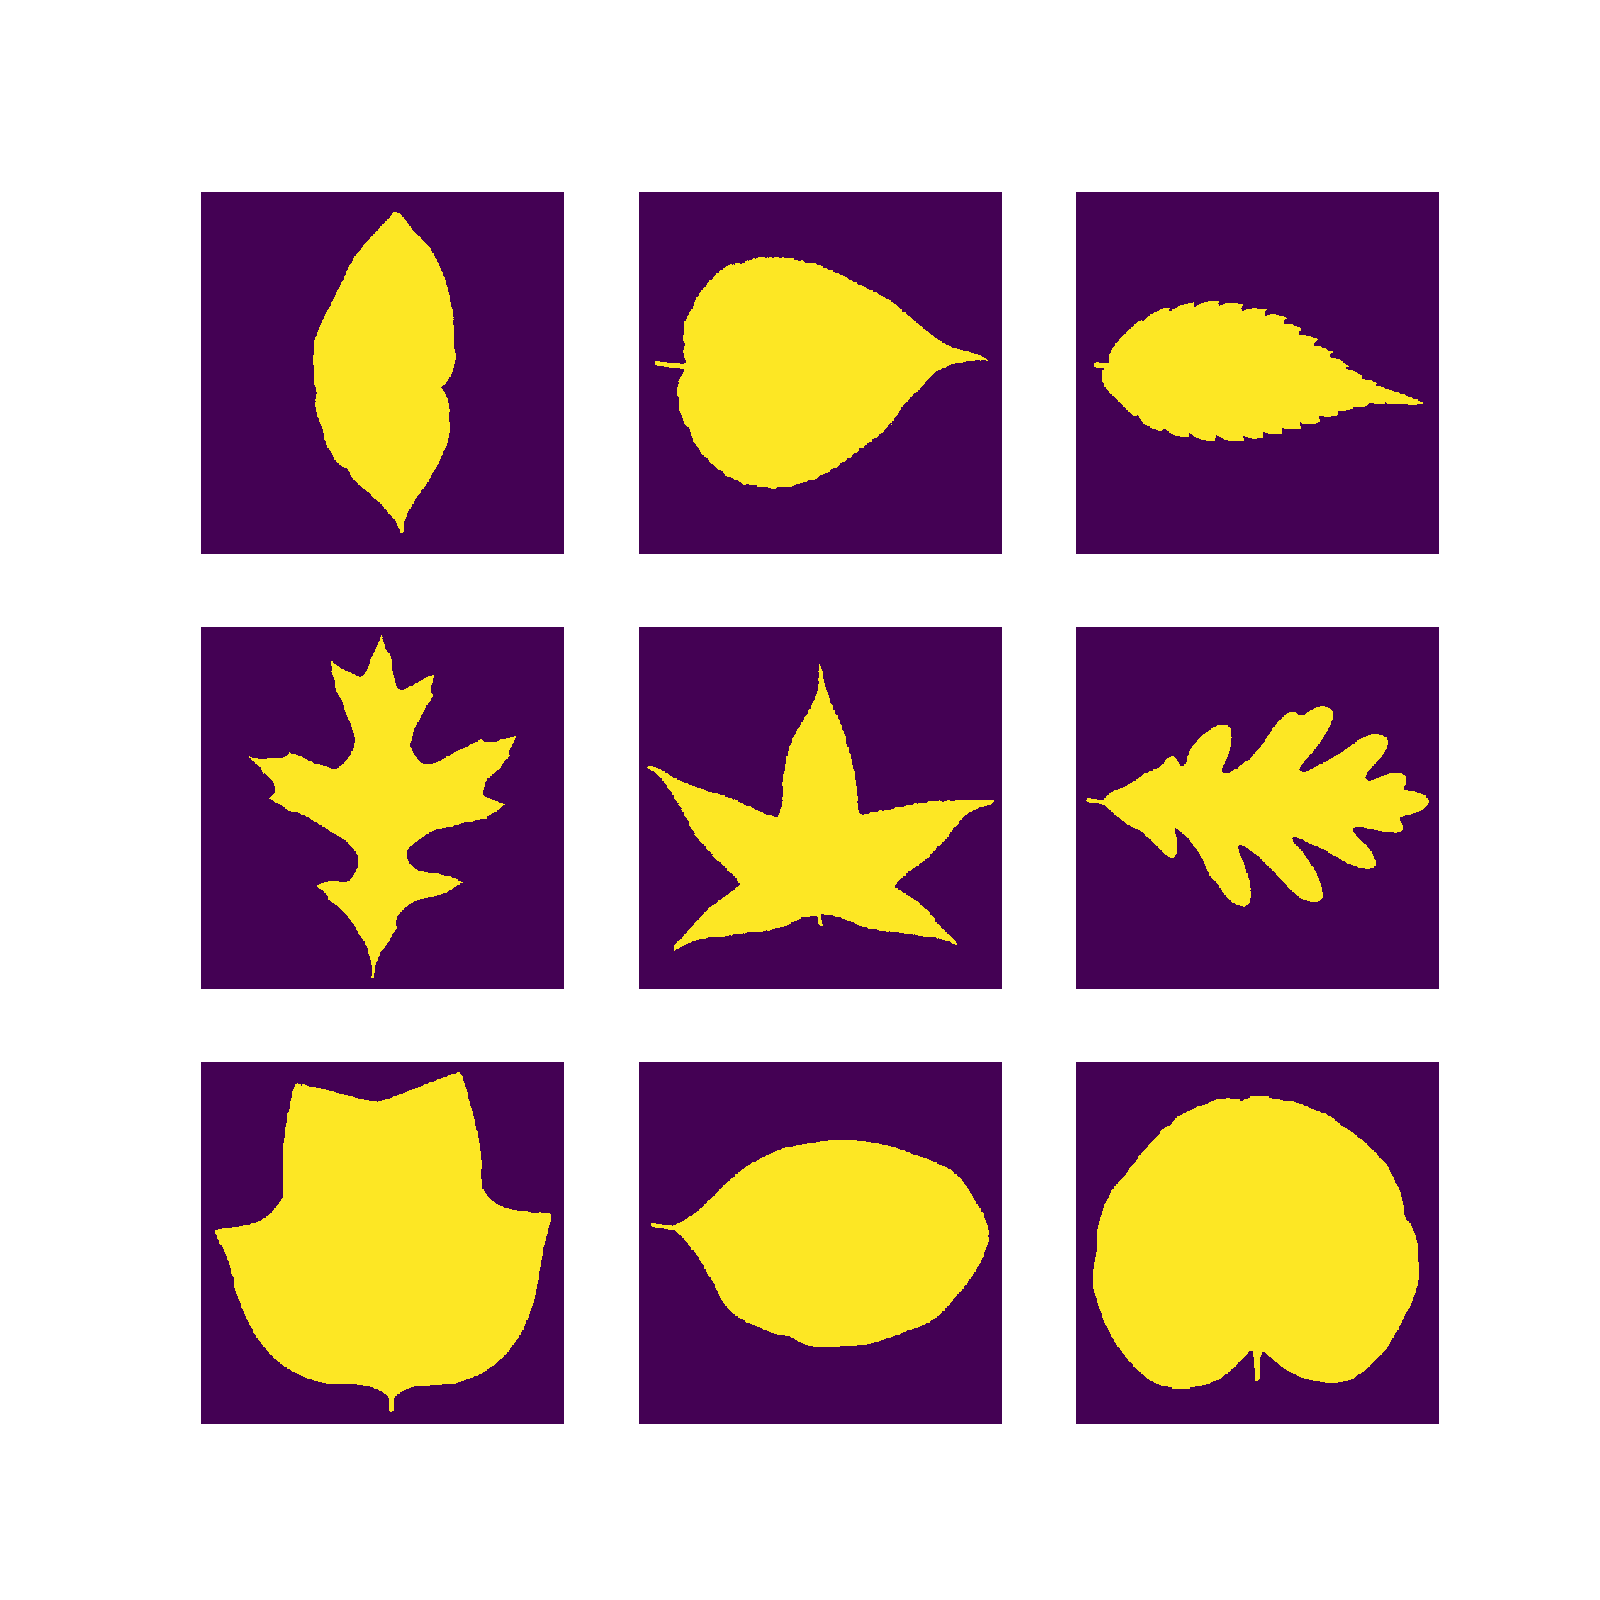

In [34]:
im, y = images_training_generator.__getitem__(2)
print(im.shape)
plt.figure(figsize=(8,8))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.axis('off')
    plt.imshow(im[i,:,:,0])

here we define the images model

In [35]:
def images_model():
    #image = Input(shape=(image_max_size, image_max_size, 1), name='image')
    image = keras.engine.input_layer.Input(shape=(image_max_size, image_max_size, 1), name='image')
    # Pass it through the first convolutional layer
    x = Conv2D(12, (4, 4), activation = 'relu')(image)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Conv2D(32, (4, 4),  activation = 'relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Conv2D(32, (4, 4),  activation = 'relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)

    x = (Conv2D(16, (4, 4),  activation = 'relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)

    #x = (Conv2D(16, (5, 5),  activation = 'relu'))(x)
    #x = (MaxPooling2D(pool_size=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)
    # Define the pre-extracted feature input
    x = Dropout(.5)(x)

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu',name='dense_for_ens')(x)

    # Get the final output
    out = Dense(n_cats, activation='softmax')(x)
    # How we create models with the Functional API
    model = Model(inputs=image, outputs=out)

    return model

In [36]:
model = images_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 509, 509, 12)      204       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 254, 254, 12)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 251, 251, 32)      6176      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 122, 122, 32)      16416     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 61, 61, 32)        0         
__________

In [37]:
model.fit_generator(images_training_generator, 
                    validation_data=images_validation_generator,
                    epochs=100, 
                    callbacks = callbacks)

Epoch 1/100
49/49 [==============================] - 3s 64ms/step - loss: 4.2770 - acc: 0.0804 - val_loss: 2.9543 - val_acc: 0.3229
Epoch 2/100
49/49 [==============================] - 2s 44ms/step - loss: 1.9245 - acc: 0.4860 - val_loss: 1.9913 - val_acc: 0.4688
Epoch 3/100
49/49 [==============================] - 2s 45ms/step - loss: 1.0099 - acc: 0.7092 - val_loss: 1.9908 - val_acc: 0.5312
Epoch 4/100
49/49 [==============================] - 2s 45ms/step - loss: 0.6272 - acc: 0.8138 - val_loss: 1.9339 - val_acc: 0.5312
Epoch 5/100
49/49 [==============================] - 2s 46ms/step - loss: 0.4735 - acc: 0.8406 - val_loss: 1.8308 - val_acc: 0.6146
Epoch 6/100
49/49 [==============================] - 2s 45ms/step - loss: 0.2754 - acc: 0.9043 - val_loss: 1.8685 - val_acc: 0.5625
Epoch 7/100
49/49 [==============================] - 2s 45ms/step - loss: 0.2690 - acc: 0.9158 - val_loss: 1.9166 - val_acc: 0.5729
Epoch 8/100
49/49 [==============================] - 2s 45ms/step - loss: 0.

The intention of this notebook is not to generate the **best** model, however here worths to mention that this model overfits and is not generalizing well.
Note the difference between the accuracy of the training and the validation set.


In [38]:
history = model.history.history
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

<IPython.core.display.Javascript object>


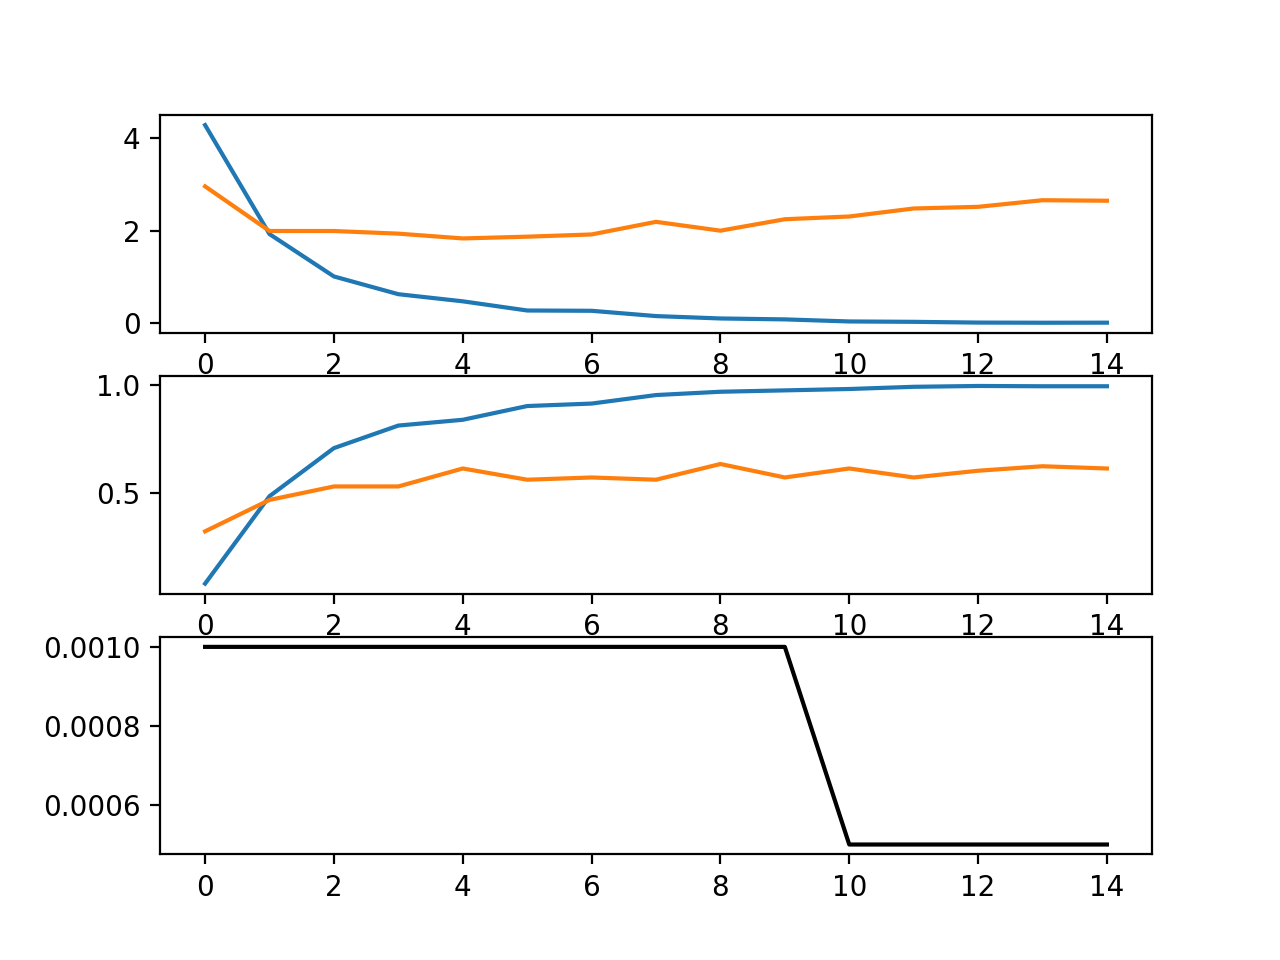

In [39]:
plt.figure()
ax1 = plt.subplot(3,1,1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.subplot(3,1,2, sharex=ax1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.subplot(3,1,3, sharex=ax1)
plt.plot(history['lr'], color='black')

### Data augmentation

#### Testing data augmentation

here we use the keras image data generator for the augmentation

In [40]:
from keras.preprocessing.image import ImageDataGenerator

In [41]:
test_augmentator= ImageDataGenerator(
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=30,
        zoom_range=0.1,
        width_shift_range=0.02,
        height_shift_range=0.02,
        horizontal_flip=True,
        vertical_flip=True)

In [42]:
ims, ys = test_augmentator.flow(X_img_tr, y_tr, batch_size=9).next()

<IPython.core.display.Javascript object>


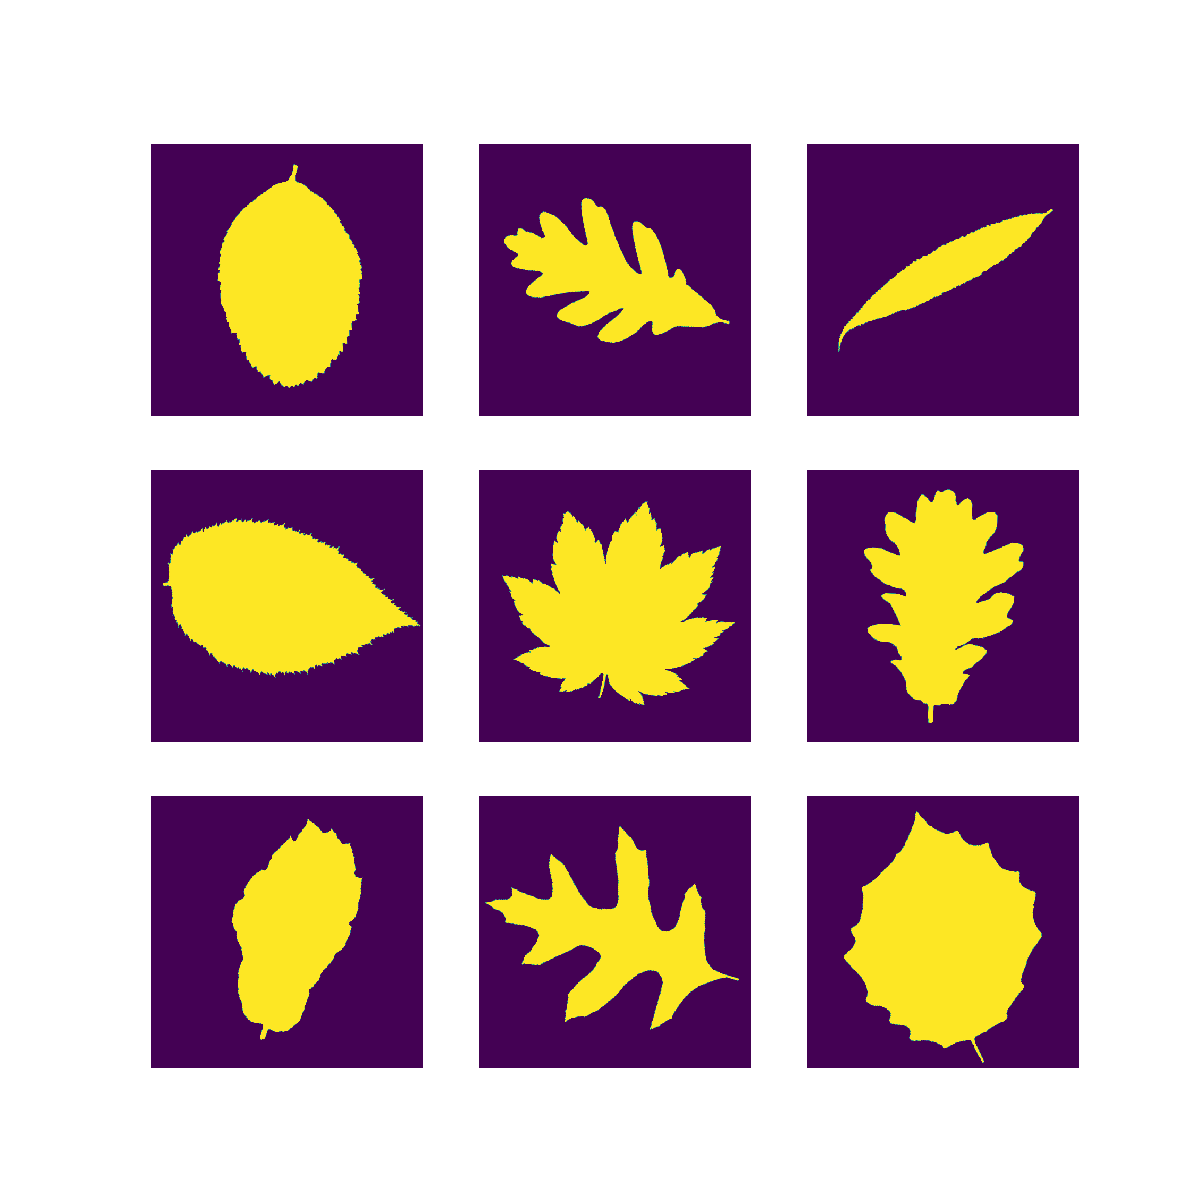

In [43]:
plt.figure(figsize=(6,6))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.axis('off')
    plt.imshow(ims[i,:,:,0])
    

### Data generator with augmentation

we make a generator with augmentation.

The key point here compared with the generator from above is that in the method \_\_data_generation we implement the ImageDataGenerator from keras.

**Note**: the performance of this generator is very poor compared with the other. Try to find out why!

In [49]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator

class ImageGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, features, targets, 
                 n_classes =99, 
                 batch_size=32,  
                 shuffle=True, 
                 repeats = 1):
        
        
        self.n_classes = n_classes
        self.n_vals = len(targets)
        # since we are using data agumentation we repeat the number of times we show each image.
        # we show the same original image but it can be rotated or flipper each time, so it is not the "same" image
        self.list_IDs = np.repeat(np.arange(self.n_vals),repeats) #OJO con esto, deberian ser las imagenes validas si queremos hacer bien las cosas
        self.batch_size = batch_size
        self.features = features
        self.shuffle = shuffle
        self.targets = targets
        self.targets_mc = keras.utils.to_categorical(targets, num_classes=self.n_classes)
        self.indexes = np.arange(len(self.list_IDs))
        
        self.agumentator = ImageDataGenerator(
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=30,
        zoom_range=0.1,
        width_shift_range=0.01,
        height_shift_range=0.01,
        horizontal_flip=True,
        vertical_flip=True)
          
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = self.features[list_IDs_temp]
        y = self.targets_mc[list_IDs_temp]

        X, y = self.agumentator.flow(X, y, batch_size=self.batch_size).next()
        
#        # Generate data
#        for i, ID in enumerate(list_IDs_temp):
#            # Store sample
#            X[i,] = np.load('data/' + ID + '.npy')
#
#            # Store class
#            y[i] = self.labels[ID]

        return X, y

###### This is an attempt to speed up the augmentation process. 

I [opened an issue in keras](https://github.com/keras-team/keras/issues/12120) and I took this idea from there. For the moment it is not working fast.

In [50]:
from multiprocessing.pool import ThreadPool

import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import OrderedEnqueuer


class ImageGeneratorParallel(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, features, targets,
                 n_classes=99,
                 batch_size=32,
                 shuffle=True,
                 repeats=1,
                 parallel = True):
        self.n_classes = n_classes
        self.n_vals = len(targets)
        # since we are using data agumentation we repeat the number of times we show each image.
        # we show the same original image but it can be rotated or flipper each time, so it is not the "same" image
        self.list_IDs = np.repeat(np.arange(self.n_vals),
                                  repeats)  # OJO con esto, deberian ser las imagenes validas si queremos hacer bien las cosas
        self.batch_size = batch_size
        self.features = features
        self.shuffle = shuffle
        self.targets = targets
        self.targets_mc = keras.utils.to_categorical(targets, num_classes=self.n_classes)
        self.indexes = np.arange(len(self.list_IDs))
        self.pool = None
        self.parallel = parallel

        self.agumentator = ImageDataGenerator(
            # featurewise_center=True,
            # featurewise_std_normalization=True,
            rotation_range=30,
            zoom_range=0.1,
            width_shift_range=0.01,
            height_shift_range=0.01,
            horizontal_flip=True,
            vertical_flip=True)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if self.parallel:
            if self.pool is None:
                self.pool = ThreadPool(4)
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        if self.parallel:
            X, y = self.__data_generation_threads(list_IDs_temp)
        else:
            X, y = self.__data_generation(list_IDs_temp)        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = self.features[list_IDs_temp]
        y = self.targets_mc[list_IDs_temp]
        X = np.array(self.agumentator.flow(X, batch_size=self.batch_size, shuffle=self.shuffle).next())

        return X, y

    def __data_generation_threads(self, list_IDs_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = self.features[list_IDs_temp]
        y = self.targets_mc[list_IDs_temp]
        X = np.array(self.pool.map(lambda xi: self.agumentator.random_transform(self.agumentator.standardize(xi)), X))

        return X, y

generate model

In [51]:
model = images_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

Note that we are using different generators for the training and validation set.

In the training set we use the same image `augmentation_image_repetition`
 times but the repetitions are different samples from the augmentator, so probably the differ each other and can be thought as different images.

In [52]:
augmentation_image_repetition = 3
batch_size = 16
params = {'batch_size': batch_size,
          'n_classes': 99,
          'shuffle': True,}
images_validation_generator = DataGenerator(X_img_val,y_val, **params) # <-- no augmentation



params['repeats'] = augmentation_image_repetition
images_training_generator = ImageGenerator(X_img_tr,y_tr, **params)


In [ ]:
#model.fit_generator(images_training_generator, 
#                    validation_data=images_validation_generator,
#                    epochs=100, 
#                    callbacks = callbacks
#                   )

model.fit_generator(images_training_generator, 
                    validation_data=images_validation_generator,
                    epochs=100, 
                    callbacks = callbacks,
                    use_multiprocessing=True,
                    max_queue_size=12,
                    workers=4
                   )

Epoch 1/100
148/148 [==============================] - 24s 162ms/step - loss: 4.4576 - acc: 0.0203 - val_loss: 3.5000 - val_acc: 0.0938
Epoch 2/100
148/148 [==============================] - 21s 139ms/step - loss: 2.9845 - acc: 0.1917 - val_loss: 2.5237 - val_acc: 0.3021
Epoch 3/100
148/148 [==============================] - 21s 141ms/step - loss: 2.3898 - acc: 0.3024 - val_loss: 2.1413 - val_acc: 0.3333
Epoch 4/100
148/148 [==============================] - 21s 143ms/step - loss: 2.1632 - acc: 0.3522 - val_loss: 1.9069 - val_acc: 0.4062
Epoch 5/100
148/148 [==============================] - 22s 148ms/step - loss: 1.8686 - acc: 0.4177 - val_loss: 1.7976 - val_acc: 0.4271
Epoch 6/100
148/148 [==============================] - 22s 148ms/step - loss: 1.7273 - acc: 0.4485 - val_loss: 1.5806 - val_acc: 0.5521
Epoch 7/100
148/148 [==============================] - 20s 138ms/step - loss: 1.5671 - acc: 0.4932 - val_loss: 1.7310 - val_acc: 0.4583
Epoch 8/100
148/148 [===========================

Note that we improved the performance in the validation set. Although the model it still overfitting, the performance is much better.

In [ ]:
history = model.history.history
plt.figure()
ax1 = plt.subplot(3,1,1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.subplot(3,1,2, sharex=ax1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.subplot(3,1,3, sharex=ax1)
plt.plot(history['lr'], color='black')

one last try with more data augmentation

In [ ]:
augmentation_image_repetition = 5
batch_size = 16

model = images_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


params = {'batch_size': batch_size,
          'n_classes': 99,
          'shuffle': True,}
images_validation_generator = DataGenerator(X_img_val,y_val, **params) # <-- no augmentation
params['repeats'] = augmentation_image_repetition
images_training_generator = ImageGenerator(X_img_tr,y_tr, **params)


model.fit_generator(images_training_generator, 
                    validation_data=images_validation_generator,
                    epochs=100, 
                    callbacks = callbacks,
                    use_multiprocessing=True,
                    max_queue_size=10,
                    workers=4)

Note that using data augmentation with 5 repetitions makes the network to generalize better.

In [ ]:
history = model.history.history
plt.figure()
ax1 = plt.subplot(3,1,1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.subplot(3,1,2, sharex=ax1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.subplot(3,1,3, sharex=ax1)
plt.plot(history['lr'], color='black')

In [ ]:
#model.save('./model_image_5_repts.h5')

# Features and Image generator


First we are going to build a generator that returns both, images and features.

This generator is a mix of the two previous generators.
The most complicated part is the image generation with augmentation, but above you can see an example of just this.

#### Generator of multiple inputs!

There is not much documentation online on how to make a generator that produces two inputs. The **key point** is in the `__getitem__` method: We have to return a tuple with a list of the inputs and the output value: `return ([Xf,Xi], y)`

In [ ]:
class EnsembleGenerator(keras.utils.Sequence):

    def __init__(self, x_tuple, targets, 
                 n_classes =99, 
                 batch_size=32,  
                 shuffle=True,
                 repeats = 1,
                 validate = False):

        # in validation mode we want the data as it comes, no agumentation or changes
        self.validate = validate
        if self.validate:
            repeats = 1
            
        features, images = x_tuple[0], x_tuple[1]
        self.n_classes = n_classes
        self.n_vals = len(targets)
        # since we are using data agumentation we repeat the number of times we show each image.
        # we show the same original image but it can be rotated or flipper each time, so it is not the "same" image
        self.list_IDs = np.repeat(np.arange(self.n_vals),repeats) #NOTE: this is not the best implementation for cases where you load the images from disk
        self.batch_size = batch_size
        self.features = features
        self.images = images        
        print('feature: {}'.format(self.features.shape))
        print('images: {}'.format(self.images.shape))
        self.shuffle = shuffle
        self.targets = targets
        self.targets_mc = keras.utils.to_categorical(targets, num_classes=self.n_classes)
        self.indexes = np.arange(len(self.list_IDs)) #this is ok
        
        self.agumentator = ImageDataGenerator(
                                    #featurewise_center=True,
                                    #featurewise_std_normalization=True,
                                    rotation_range=30,
                                    zoom_range=0.1,
                                    width_shift_range=0.01,
                                    height_shift_range=0.01,
                                    horizontal_flip=True,
                                    vertical_flip=True)
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        Xi, yi = self.__image_generation(list_IDs_temp)        
        Xf, yf = self.__feature_generation(list_IDs_temp)
        if np.all(yf==yi):
            y = yf
        else:
            print(np.argmax(self.targets_mc[list_IDs_temp],axis=1))
            print(np.argmax(yf, axis=1))
            print(np.argmax(yi, axis=1))
            raise ValueError('not equal')
                
            
        return ([Xf,Xi], y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.list_IDs
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __feature_generation(self, list_IDs_temp):
        y = self.targets_mc[list_IDs_temp]
        X = self.features[list_IDs_temp]
        return X, y
        
    def __image_generation(self, list_IDs_temp):
        # Initialization
        X = self.images[list_IDs_temp]
        yr = self.targets_mc[list_IDs_temp]
        if not self.validate:
#            X, y = self.agumentator.flow(X, y, batch_size=self.batch_size).next()
            X, y = self.agumentator.flow(X, yr, batch_size=len(list_IDs_temp), shuffle=False).next()            
            if not np.all(y==yr):
#                print('not equal after agumentator')
                raise Exception('not equal after agumentator')
        else:
            y = yr
        

        return X, y

Here we initialize the generators

In [ ]:
batch_size = 16
params = {'batch_size': batch_size,
          'n_classes': 99,
          'shuffle': True,
         }
params['repeats'] = 5
ensemble_training_generator = EnsembleGenerator((X_num_tr,X_img_tr),y_tr, **params)
params['validate']=True
ensemble_validate_generator = EnsembleGenerator((X_num_val,X_img_val),y_val, **params)



In [ ]:
print(ensemble_training_generator.features.shape)
print(ensemble_training_generator.images.shape)

### Definition of the architecture of the ensemble

Here we implement the ensemble based on the two previous networks. 

1. We use the defined architecture of the features, and we keep some of its layers
2. We use some of the layers of the CNN used to analyse the images
3. We ensemble this two architectures and add some more layers to generate the output.

#### Implementation of the previous architectures
Some comments:

- To implement previous defined models/architectures there is a little workaround needed to use the input layer. 
> When loading an existing model, the `model.layers[0]` is not a tensor, and in order to build the model layer, we need a tensor. Thats why we implement the input layer in a different way using `model.input`. `model.input` returns a tensor and then everything works. 

- Also note that in the two other models images_model and features_model we added the name 'dense_for_ens'. We used this as a flag to determine were to break and stop adding layers for that model to the ensemble one. We do this for the two architectures.

- Note that we ensemble the two models using a [Concatenate layer](https://keras.io/layers/merge/). In this point is important that the two input tensors have the same shape. 
> For example: We can not concatenate the output of a 2D convolutional with a Dense. We will be able to concatenate any layer after a Flatten (2D -> 1D) .

- The last thing is that `Model` now has to inputs. When there are more than one input we pass the multiple inputs a list.

In [ ]:
def ensemble_generator():

    # features architeture
    f_model = features_model()    
    feat_layers= []
    ## this method does not works
    #x = f_model.layers[0]
    #feat_layers.append(x)
    ## this method works
    #input_layer = f_model.layers[0]
    #x = Input(shape=input_layer.get_input_shape_at(0)[1:])
    # this is the neatest way I've found so far to
    input_layer = f_model.input
    x = input_layer
    feat_layers.append(x)
    for lay in f_model.layers[1:]:
        lay.name = 'feat_' + lay.name
        x = lay(x)
        feat_layers.append(x)  
        if 'dense_for_ens' in lay.name:
            break    
    
    # images architecture
    i_model = images_model()
    im_layers = []
    x = i_model.input
    im_layers.append(x)
    for lay in i_model.layers[1:]:
        lay.name = 'im_' + lay.name
        x = lay(x)
        im_layers.append(x)
        if 'dense_for_ens' in lay.name:
            break
            
    #ensemble architecture
    xe = Concatenate(axis = -1)([feat_layers[-1], im_layers[-1]])
    xe = Dropout(0.1)(xe)
    xe = Dense(100, activation='relu', name='Dense_conc')(xe)
    xe = Dense(50, activation='relu')(xe)

    # Get the final output
    out = Dense(n_cats, activation='softmax')(xe)

    # generate model
    model = Model(inputs=[feat_layers[0],im_layers[0]], outputs=out)
    
    return model

In [ ]:
ens_model = ensemble_generator()
ens_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ens_model.summary()

In [ ]:

#feature = Input(shape=(192,), name = 'feature_input')
#xf = Dense(100, activation = 'relu')(feature)
#xf = Dropout(0.3)(xf)
#xf = Dense(100, activation='relu')(xf)
#
#image = Input(shape=(image_max_size, image_max_size, 1), name='image_input')
## Pass it through the first convolutional layer
#xi = Conv2D(12, (6, 6), activation = 'relu')(image)
#xi = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(xi)
#xi = (Conv2D(32, (4, 4),  activation = 'relu'))(xi)
#xi = (MaxPooling2D(pool_size=(2, 2)))(xi)
#xi = (Conv2D(32, (4, 4),  activation = 'relu'))(xi)
#xi = (MaxPooling2D(pool_size=(2, 2)))(xi)
#xi = (Conv2D(16, (4, 4),  activation = 'relu'))(xi)
#xi = (MaxPooling2D(pool_size=(2, 2)))(xi)
#if image_max_size>256:
#    xi = (Conv2D(16, (4, 4),  activation = 'relu'))(xi)
#    xi = (MaxPooling2D(pool_size=(2, 2)))(xi)
#xi = Flatten()(xi) # Flatten our array
#xi = Dropout(.5)(xi)
#xi = Dense(100, activation='relu')(xi)
#
#xe = Concatenate(axis = -1)([xf, xi])
#xe = Dropout(0.1)(xe)
#xe = Dense(100, activation='relu', name='Dense_conc')(xe)
#xe = Dense(50, activation='relu')(xe)
#
## Get the final output
#out = Dense(n_cats, activation='softmax')(xe)
## How we create models with the Functional API
#model = Model(inputs=[feature,image], outputs=out)
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()
#
#

In [ ]:
ens_model.fit_generator(ensemble_training_generator, 
                    validation_data=ensemble_validate_generator,
                    epochs=100, 
                    callbacks = callbacks,
                    use_multiprocessing = True,
                    #max_queue_size = 10,
                    #workers=4
                       )

Although the intention of this notebook was to discuss some points on the implementation of the ensemble and the fit generation, it is worth to notice that after ensembling, the performance of the model increases.

In [ ]:
history = ens_model.history.history
plt.figure()
ax1 = plt.subplot(3,1,1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.subplot(3,1,2, sharex=ax1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.subplot(3,1,3, sharex=ax1)
plt.plot(history['lr'], color='black')

### Last comments about performance

to increase the performance (accuracy for example) of the model we could try to do some _transfer learning_: we can implement a resnet as the backbone of the images_model with it first layers frozen and just train the last fully connected layers and use this ones to feed the ensemble.

Additionally we can try to generate a more complex architecture for the features model to increase the performance of this model and then feed the ensemble with one of these layers.